In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from sklearn import preprocessing

from math import ceil, floor
from tqdm import tqdm
%matplotlib inline

In [185]:
def rmspe(y_hat, y):
    idx = y != 0
    w = np.zeros(y.shape, dtype=float)
    w[idx] = 1. / (y[idx]**2)
    rmspe = np.sqrt(np.mean(w * (y_hat - y)**2))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    
    idx = y != 0
    w = np.zeros(y.shape, dtype=float)
    w[idx] = 1. / (y[idx]**2)
    
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [190]:
df_train = pd.read_csv('dataset/train.csv', parse_dates=['Date'], date_parser=(lambda time: pd.to_datetime(time, format='%Y-%m-%d')))
df_submit = pd.read_csv('dataset/test.csv', parse_dates=['Date'], date_parser=(lambda time: pd.to_datetime(time, format='%Y-%m-%d')))
df_store = pd.read_csv('dataset/store.csv')


df_train['isTrain'] = 1
df_submit['isTrain'] = 0

In [191]:
frames = [df_train, df_submit]
df = pd.concat(frames)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 41087
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058286 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
isTrain          1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [203]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [204]:
## Deal with abnormal data
### Remove rows where store is open but no sales
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]
df.loc[df['isTrain'] == 1, 'SalesLog'] = np.log1p(df.loc[df['isTrain'] == 1]['Sales'])

In [205]:
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes

In [206]:
_ = 'Date'
date = pd.Index(df[_])
df[_ + 'Day'] = pd.Series(date.day).fillna(0)
df[_ + 'Month'] = pd.Series(date.month).fillna(0)
df[_ + 'Week'] = pd.Series(date.week).fillna(0)
df[_ + 'Year'] = pd.Series(date.year).fillna(0)
df[_ + 'DayOfYear'] = pd.Series(date.dayofyear).fillna(0)

features_x.remove(_)
features_x = features_x + [_ + 'Day', _ + 'Month', _ + 'Week', _ + 'Year', _ + 'DayOfYear']

In [93]:
df_store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,NaN,NaN,NaN,0.000000,NaN,NaN
50%,558.00000,NaN,NaN,NaN,1.000000,NaN,NaN
75%,836.50000,NaN,NaN,NaN,1.000000,NaN,NaN
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [207]:
df_store['StoreType'] = df_store['StoreType'].astype('category').cat.codes
df_store['Assortment'] = df_store['Assortment'].astype('category').cat.codes

In [208]:
def convertCompetitonOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan
    
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan
    
def convertMonth(mon):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[mon]

df_store['CompetitionSinceOpen'] = df_store.apply(lambda df: convertCompetitonOpen(df), axis=1).astype(np.int64)
df_store['Promo2Since'] = df_store.apply(lambda df:convertPromo2(df), axis=1).astype(np.int64)

months = df_store['PromoInterval'].str.split(',').apply(pd.Series, 1)
months.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
df_store = df_store.join(months)

for i in range(4):
    df_store['PromoInterval' + str(i)] = df_store['PromoInterval' + str(i)].map(lambda x: convertMonth(x) if str(x) != 
                                                                               'nan' else np.nan)

In [209]:
store_features = ['StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionSinceOpen', 'PromoInterval0', 'Promo2Since', 'Promo2']
features_x = list(set(features_x + store_features))
store_features.append('Store')

In [210]:
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

### Convert NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

## Visual

['DayOfWeek', 'DateWeek', 'CompetitionSinceOpen', 'StateHoliday', 'Promo2Since', 'Promo', 'CompetitionDistance', 'DateDay', 'DateYear', 'DateDayOfYear', 'DateMonth', 'PromoInterval0', 'StoreType', 'Assortment', 'Promo2', 'SchoolHoliday', 'Store']


/Users/Chu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Users/Chu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


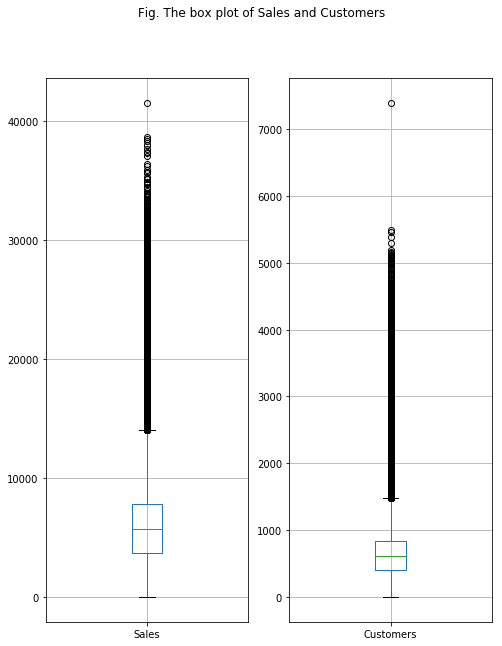

In [120]:
print features_x
plt.figure(figsize=(8,10))
plt.subplot(1,2,1)
df[['Sales']].boxplot()
plt.subplot(1,2,2)
df[['Customers']].boxplot()
plt.suptitle('Fig. The box plot of Sales and Customers')

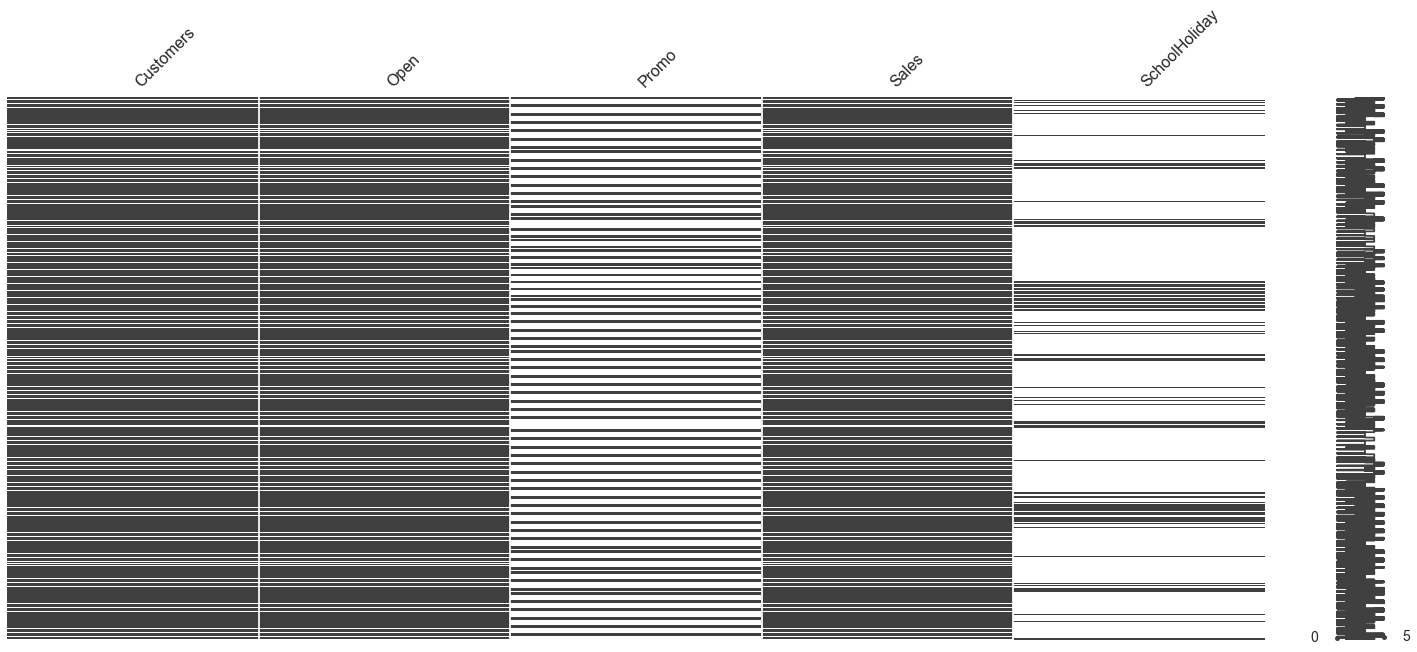

In [201]:
# import missingno as msno
train = df[df['isTrain'] == 1]
ts = train.Sales.values.tolist()
null_pattern = train[['Customers', 'Open', 'Promo', 'Sales', 'SchoolHoliday']].replace({False: None})
msno.matrix(null_pattern.set_index(train.Date.values) , freq='BQ')

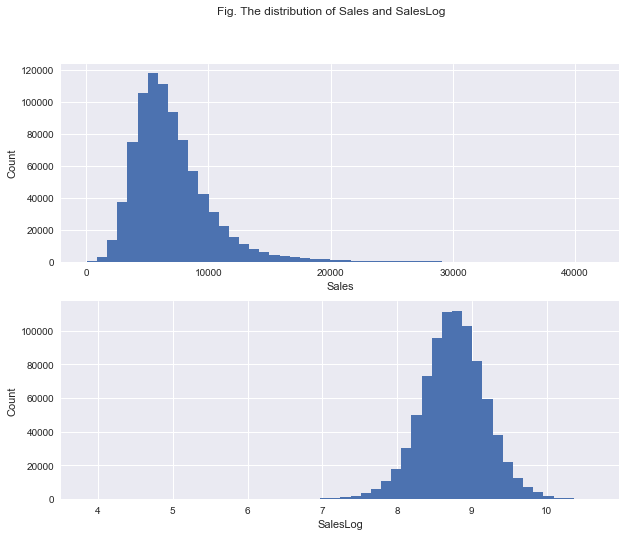

In [224]:
plt.figure(figsize=(10,8))
day = df.loc[(df['Open'] == 1) & (df['isTrain'] == 1)]
plt.subplot(2,1,1)
ax1 = day.loc[day.Sales > 0, 'Sales'].hist(bins = 50)
ax1.set_ylabel('Count')
ax1.set_xlabel('Sales')
plt.subplot(2,1,2)
ax2 = day.loc[day.Sales > 0, 'SalesLog'].hist(bins = 50)
ax2.set_ylabel('Count')
ax2.set_xlabel('SalesLog')
plt.suptitle('Fig. The distribution of Sales and SalesLog')

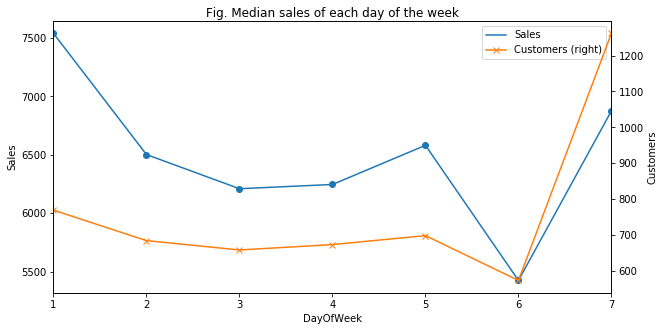

In [47]:
day_sales = day.groupby('DayOfWeek')['Sales'].median()
day_customers = day.groupby('DayOfWeek')['Customers'].median()

figure, axis1 = plt.subplots(1, 1, sharex=True, figsize=(10, 5))

ax1 = day_sales.plot(legend=True, ax=axis1, marker='o', title="Fig. Median sales of each day of the week")
ax1.set_xticks(day_sales.index)
ax1.set_ylabel('Sales')
tmp = ax1.set_xticklabels(day_sales.index.tolist(), rotation=90)

ax2 = day_customers.plot(legend=True, ax=axis1, marker='x', secondary_y=True)
ax2.set_ylabel('Customers')

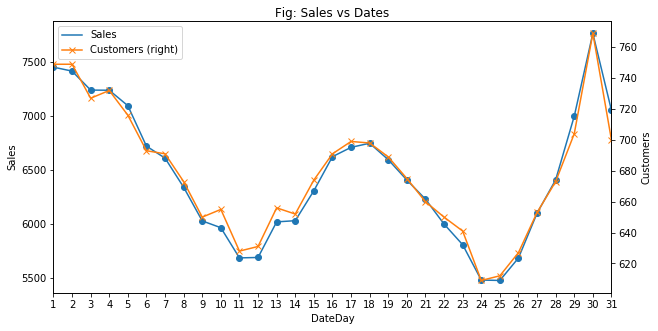

In [48]:
day_sales = day.groupby('DateDay')['Sales'].median()
day_customers = day.groupby('DateDay')['Customers'].median()

fig, axis1 = plt.subplots(1, 1, sharex=True, figsize=(10, 5))

ax1 = day_sales.plot(legend=True, ax=axis1, marker='o', title="Fig: Sales vs Dates")
ax1.set_xticks(day_sales.index)
ax1.set_ylabel('Sales')
tmp = ax1.set_xticklabels(day_sales.index.tolist(), rotation=90)

ax2 = day_customers.plot(legend=True, ax=axis1, marker='x', secondary_y=True)
ax2.set_ylabel('Customers')

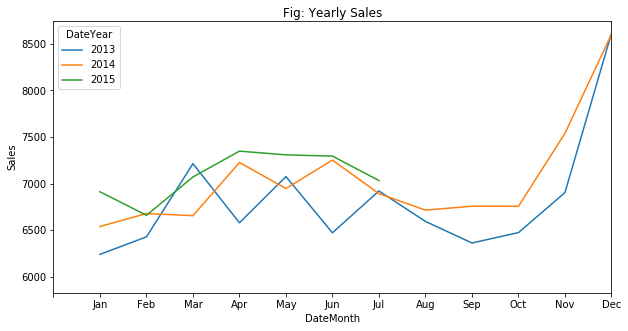

In [26]:
import calendar
months_sales = day.groupby(['DateYear', 'DateMonth'])['Sales'].mean()
months_customers = day.groupby(['DateYear', 'DateMonth'])['Customers'].mean()

fig, axis1 = plt.subplots(1, 1, figsize=(10, 5))
months_sales.unstack().T.plot(ax=axis1)
axis1.set_title("Fig: Yearly Sales")
axis1.set_ylabel("Sales")
axis1.set_xticks(range(0,13))
tmp = axis1.set_xticklabels(calendar.month_abbr)

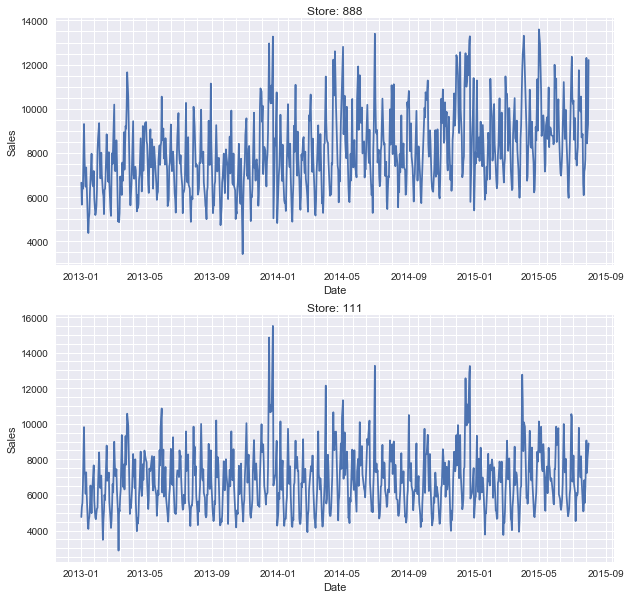

In [225]:
stores_to_visual = [888,111]

plt.rcParams["figure.figsize"] = [10,len(stores_to_visual)*5]

j = 1
for i in stores_to_visual:
    stor = i

    # Normal sales
    X1 = df.loc[(df['isTrain'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]
    y1 = df.loc[(df['isTrain'] == 1) & (df['Store'] == stor) & (df['Open'] == 1)]['Sales']

    Xt = df.loc[(df['Store'] == stor)]
    
    ax = plt.subplot(len(stores_to_visual),1,j)
    ax.set_title('Store: ' + str(i))
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.plot(X1['Date'], y1)
    plt.minorticks_on()
    plt.grid(True, which='both')
    j += 1
plt.show()

## Outliers

In [86]:
train = df[df['isTrain'] == 1]
Q1 = np.percentile(train['Sales'], 25)
Q3 = np.percentile(train['Sales'], 75)
step = step = 1.5 * (Q3 - Q1)
i=train[~((train['Sales'] >= Q1 - step) & (train['Sales'] <= Q3 + step))].index
print "Number of outliers in sales =", len(i)

Q1 = np.percentile(train['Customers'], 25)
Q3 = np.percentile(train['Customers'], 75)
step = step = 1.5 * (Q3 - Q1)
j=train[~((train['Customers'] >= Q1 - step) & (train['Customers'] <= Q3 + step))].index
print "Number of outliers in customers =", len(j)

common_outliers = set(i).intersection(j)
print "Number of common outliers =", len(common_outliers)

train = train.drop(train.index[list(common_outliers)]).reset_index(drop = True)
df.loc[list(common_outliers), 'Outlier'] = True
df.Outlier = df.Outlier.fillna(False)
#train.loc[list(common_outliers), 'Outlier'] = True

print float(len(common_outliers))*100/float(train.shape[0]), "% dropped"

Number of outliers in sales = 26701
Number of outliers in customers = 38095
Number of common outliers = 18985
1.90198062454 % dropped


## Split Data for Filling in the Outliers

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train.loc[(train['Open'] == 1)][features_x], 
                                                   train.loc[(train['Open'] == 1)][features_y],
                                                   test_size=0.1, random_state=1)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [22]:
store_sales = train.groupby([train['Store']])['Sales'].sum()
store_customers = train.groupby([train['Store']])['Customers'].sum()
store_open = train.groupby([train['Store']])['Open'].count()

store_sales_per_day = store_sales / store_open
store_customers_per_day = store_customers / store_open
store_sales_per_customer_per_day = store_sales_per_day / store_customers_per_day

In [23]:
df_store = pd.merge(df_store, store_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']
features_x = features_x + store_features
features_x.remove('Store')
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['isTrain'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_x],
                                                    df.loc[(df['isTrain'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)][features_y],
                                                    test_size=0.1, random_state=1)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
num_round = 20000
evallist = [(dtrain, 'train'), (dtest, 'test')]
param = {'bst:max_depth':12,
         'bst:eta':0.0095,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1, 
         'objective':'reg:linear',
         'nthread':6,
         'seed':1}

plst = param.items()

bst1 = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmse:5.77633	test-rmse:5.77266	train-rmspe:0.996805	test-rmspe:0.99679
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.109321	test-rmse:0.111667	train-rmspe:0.175612	test-rmspe:0.123745
[500]	train-rmse:0.097178	test-rmse:0.10127	train-rmspe:0.143287	test-rmspe:0.113422
[750]	train-rmse:0.091429	test-rmse:0.096905	train-rmspe:0.132774	test-rmspe:0.108647
[1000]	train-rmse:0.087577	test-rmse:0.09441	train-rmspe:0.11713	test-rmspe:0.105722
[1250]	train-rmse:0.084792	test-rmse:0.092916	train-rmspe:0.105848	test-rmspe:0.104013
[1500]	train-rmse:0.082666	test-rmse:0.091826	train-rmspe:0.103102	test-rmspe:0.102972
[1750]	train-rmse:0.080783	test-rmse:0.091077	train-rmspe:0.092544	test-rmspe:0.102263
[2000]	train-rmse:0.079257	test-rmse:0.09048	train-rmspe:0.089713	test-rmspe:0.100944
[2250]	train-rmse:0.077892	test-rmse:0.090068	train-rmspe:0.086952	test-rmspe:0.1005

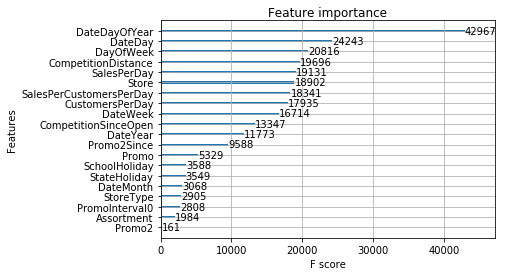

In [28]:
xgb.plot_importance(bst1)

In [29]:
dpred = xgb.DMatrix(X_test)
y_pred = bst1.predict(dpred)

In [30]:
def evaluate(y_pred, y):
    y_pred1 = (np.exp(y_pred) - 1) * 0.985
    y_test1 = (np.exp(y) - 1)
    y_test1 = np.array(y_test1.SalesLog.tolist(), dtype=np.float32)
    return rmspe(y_pred1, y_test1)

In [31]:
evaluate(y_pred, y_test)

0.098454259197867586

In [42]:
X_submit = df.loc[df['isTrain'] == 0]
dsubmit = xgb.DMatrix(X_submit[features_x])

ypred_bst = bst1.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(ypred_bst) - 1) * 0.985

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_XGB.csv', index=False)

__XGBoost Public Score: 0.15988__

In [43]:
train = df.loc[(df['isTrain'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]

In [44]:
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

X_train, X_test = cross_validation.train_test_split(train, test_size=0.25)

print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 619014 samples.
Testing set has 206339 samples.


In [45]:
rgr = DecisionTreeRegressor(random_state=1)
rgr.fit(X_train[features_x], X_train[features_y])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [46]:
y_pred = rgr.predict(X_test[features_x])

evaluate(y_pred, X_test[features_y])

0.25999396944118597

In [47]:
from sklearn.grid_search import GridSearchCV

param_grid = {"min_samples_split": [20, 15, 30],
              "max_depth": [None, 2, 6, 12],
              "min_samples_leaf": [12, 8, 16]
              }
grid_search = GridSearchCV(rgr,param_grid=param_grid)
grid_search.fit(X_train[features_x], X_train[features_y])

y_pred = grid_search.predict(X_test[features_x])

print "Best parameters:", grid_search.best_params_
print "RMSE:", evaluate(y_pred, X_test[features_y])

Best parameters: {'min_samples_split': 30, 'max_depth': None, 'min_samples_leaf': 8}
RMSE: 0.256384362585


In [48]:
print len(rgr.feature_importances_)
print features_x
features = pd.Series(rgr.feature_importances_, index=features_x)

20
['DayOfWeek', 'DateWeek', 'CompetitionSinceOpen', 'StateHoliday', 'Promo2Since', 'Promo', 'CompetitionDistance', 'DateDay', 'DateYear', 'DateDayOfYear', 'DateMonth', 'PromoInterval0', 'StoreType', 'Assortment', 'Promo2', 'SchoolHoliday', 'Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']


SalesPerDay                0.537570
Promo                      0.177796
DayOfWeek                  0.056539
DateDayOfYear              0.042711
DateDay                    0.033401
CompetitionDistance        0.022776
CustomersPerDay            0.018466
SalesPerCustomersPerDay    0.016819
DateWeek                   0.014697
Store                      0.013891
StoreType                  0.012970
DateYear                   0.012368
CompetitionSinceOpen       0.012041
Promo2Since                0.007725
DateMonth                  0.005914
Assortment                 0.004213
SchoolHoliday              0.003151
StateHoliday               0.003033
PromoInterval0             0.002894
Promo2                     0.001027
dtype: float64


/Users/Chu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


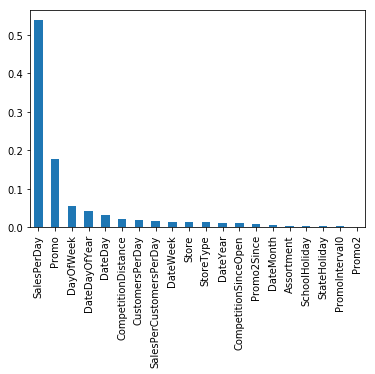

In [49]:
features.sort(ascending=False)
print features
features.plot(kind='bar')

In [50]:
X_submit = df.loc[df['isTrain'] == 0]
y_pred = grid_search.predict(X_submit[features_x])

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

# Scale back the sales a bit
df_ypred['Sales'] = (np.exp(y_pred) - 1) * 0.985

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_DT.csv', index=False)

__Decision Tree Public Score: 0.18030__

In [ ]:
## Ensemble

In [57]:
df1 = pd.read_csv('rossmann_DT.csv')
df2 = pd.read_csv('rossmann_XGB.csv')

In [58]:
df1.Sales = df1.Sales*0.35 + df2.Sales*0.65

In [60]:
df1.to_csv('rossman_E.csv', index=False)

__Final Public score: 0.15580__